In [350]:
import pytesseract
from PIL import Image
import re
import os
import numpy as np
import pandas as pd
import torch
import tqdm

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [351]:
torch.cuda.is_available()

True

In [352]:

allowed_units = {"centilitre", "centimetre", "cubicfoot", "cubicinch", "cup", "decilitre", "fluidounce", "foot", "gallon", "gram", "imperialgallon", "inch", "kilogram", "kilovolt", "kilowatt", "litre", "metre", "microgram", "microlitre", "milligram", "millilitre", "millimetre", "millivolt", "ounce", "pint", "pound", "quart", "ton", "volt", "watt", "yard"}
# Define the allowed units
allowed_units = {
	"centilitre", "centimetre", "cubicfoot", "cubicinch", "cup", "decilitre", 
	"fluidounce", "foot", "gallon", "gram", "imperialgallon", "inch", "kilogram", 
	"kilovolt", "kilowatt", "litre", "metre", "microgram", "microlitre", 
	"milligram", "millilitre", "millimetre", "millivolt", "ounce", "pint", 
	"pound", "quart", "ton", "volt", "watt", "yard"
}

# Define the abbreviation mapping
mapping = {
	"cl": "centilitre",
	"cm": "centimetre",
	"ft": "foot",
	"in": "inch",
	"g": "gram",
	"kg": "kilogram",
	"l": "litre",
	"m": "metre",
	"mg": "milligram",
	"ml": "millilitre",
	"oz": "ounce",
	"pt": "pint",
	"qt": "quart",
	"lb": "pound",
	"gal": "gallon",
	"cf": "cubicfoot",
	"ci": "cubicinch",
	"floz": "fluidounce",
	"dl": "decilitre",
	"µg": "microgram",
	"µl": "microlitre",
	"mv": "millivolt",
	"kv": "kilovolt",
	"kw": "kilowatt",
	"w": "watt",
	"yd": "yard",
	"t": "ton",
	"imperialgal": "imperialgallon"
}

mapping


{'cl': 'centilitre',
 'cm': 'centimetre',
 'ft': 'foot',
 'in': 'inch',
 'g': 'gram',
 'kg': 'kilogram',
 'l': 'litre',
 'm': 'metre',
 'mg': 'milligram',
 'ml': 'millilitre',
 'oz': 'ounce',
 'pt': 'pint',
 'qt': 'quart',
 'lb': 'pound',
 'gal': 'gallon',
 'cf': 'cubicfoot',
 'ci': 'cubicinch',
 'floz': 'fluidounce',
 'dl': 'decilitre',
 'µg': 'microgram',
 'µl': 'microlitre',
 'mv': 'millivolt',
 'kv': 'kilovolt',
 'kw': 'kilowatt',
 'w': 'watt',
 'yd': 'yard',
 't': 'ton',
 'imperialgal': 'imperialgallon'}

In [353]:
temp = f'({"|".join(list(mapping.keys()))})'

temp = f'({"|".join(sorted(list(mapping.keys()), reverse=True, key=len))})'

temp

'(imperialgal|floz|gal|cl|cm|ft|in|kg|mg|ml|oz|pt|qt|lb|cf|ci|dl|µg|µl|mv|kv|kw|yd|g|l|m|w|t)'

In [354]:
train_df = pd.read_csv("dataset/train.csv")

In [355]:
train_df["image_link"] = train_df["image_link"].apply(lambda link: link.split("/")[-1])

train_df.iloc[500:511, :]


,image_link,group_id,entity_name,entity_value
500,51osfJX-RKL.jpg,483370,item_weight,10.0 gram
501,71cSLrQ6LrL.jpg,630869,item_weight,19.2 gram
502,71yBp56rqoL.jpg,932012,item_weight,2.4 gram
503,71RIelu5DKL.jpg,932012,item_weight,8.0 kilogram
504,61IjAvkDTfL.jpg,932012,item_weight,4.0 ounce
505,716moDrkaoL.jpg,181357,item_weight,12.0 pound
506,71fUbmGV03S.jpg,658003,item_weight,5.0 gram
507,91+No1yJ4tL.jpg,281678,item_volume,"[70.0, 100.0] millilitre"
508,71W7WvEFKhL.jpg,179080,voltage,36.0 volt
509,71GzvcDB6lL.jpg,801829,item_weight,150.0 kilogram


In [356]:
def get_ground_truth(filename: 'str'):
	actual_path = f"{filename.split('/')[1]}"

	# print(actual_path)

	return train_df[train_df["image_link"] == actual_path]

In [405]:
test_files = [os.path.join("downloads/", path) for path in os.listdir("downloads/")]
test_files

!rm -rf preprocessed
!mkdir preprocessed
!cp downloads/* preprocessed/

import cv2

for file in tqdm.tqdm(test_files):
	# Read the image
	# image = cv2.imread(file)
	image = Image.open(file)

	# # Apply sharpening kernel
	# sharpening_kernel = np.array([[-1, -1, -1], 
	#                               [-1,  9, -1],
	#                               [-1, -1, -1]])
	# sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)

	# # Convert the image to grayscale (since adaptiveThreshold expects a grayscale image)
	# # gray_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2GRAY)

	# # Resize the image to make it larger and sharper (use a 2x scaling factor)
	# resized_image = cv2.resize(sharpened_image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

	# # Apply bilateral filtering to reduce noise while keeping edges sharp
	# filtered_image = cv2.bilateralFilter(resized_image, 9, 75, 75)

	# Apply adaptive thresholding to get a clean black-and-white image for OCR
	# bw_image = cv2.adaptiveThreshold(filtered_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
	#                                  cv2.THRESH_BINARY, 11, 2)

	preprocessed_image, enhanced_image = preprocess_image(image)



	# Save the processed image to the 'preprocessed' directory
	output_filename = os.path.join("preprocessed", os.path.basename(file))
	# cv2.imwrite(output_filename, enhanced_image)

	enhanced_image.save(output_filename)

# List the preprocessed files (just to check)

test_files = [os.path.join("preprocessed/", path) for path in os.listdir("preprocessed/")]
test_files

100%|██████████| 98/98 [00:17<00:00,  5.75it/s]


['preprocessed/31EvJszFVfL.jpg',
 'preprocessed/413FQB0ZMLL.jpg',
 'preprocessed/41EjbFu-+yL.jpg',
 'preprocessed/41wvffSxB4L.jpg',
 'preprocessed/51b9JEHOriL.jpg',
 'preprocessed/51bQPPtMqYL.jpg',
 'preprocessed/51WsuKKAVrL.jpg',
 'preprocessed/51xfRlxWIXL.jpg',
 'preprocessed/612mrlqiI4L.jpg',
 'preprocessed/612xIhPMHqL.jpg',
 'preprocessed/61390hosjFL.jpg',
 'preprocessed/613BeFNwHcL.jpg',
 'preprocessed/613G8GOyLSL.jpg',
 'preprocessed/613v+2W4UwL.jpg',
 'preprocessed/617Tl40LOXL.jpg',
 'preprocessed/61AHQ35poHL.jpg',
 'preprocessed/61BZ4zrjZXL.jpg',
 'preprocessed/61c+hSNnnZL.jpg',
 'preprocessed/61cMeogK8gL.jpg',
 'preprocessed/61d6Kj80QSL.jpg',
 'preprocessed/61Dq3LRei9L.jpg',
 'preprocessed/61eOO5IW4NL.jpg',
 'preprocessed/61Fwq4GeTmL.jpg',
 'preprocessed/61hWZdkq6WL.jpg',
 'preprocessed/61HXgujoxpL.jpg',
 'preprocessed/61I0O1qJbhS.jpg',
 'preprocessed/61I9XdN6OFL.jpg',
 'preprocessed/61kyBEJYDeL.jpg',
 'preprocessed/61o2ntPNNgL.jpg',
 'preprocessed/61-oj+N+BxL.jpg',
 'preproce

In [358]:
image_path = test_files[5] # 100:111
image_path = test_files[9] # 500:511

image_text = str(pytesseract.image_to_string(Image.open(image_path)))

image_path

'downloads/71jBLhmTNlL.jpg'

In [359]:
def map_shorthand_unit_to_full(pair: 'tuple[str, str]'):
	
	number = pair[0]
	unit = pair[1]

	actual_unit = mapping.get(unit, "")

	return f"{number} {actual_unit}"

map_shorthand_unit_to_full(("9.8", "g"))
map_shorthand_unit_to_full(("38", "ml"))

'38 millilitre'

In [360]:
lines = re.split(r"\n+", image_text)


possible = []


for line in lines:

	line = line.lower()
	# Basic working	

	pattern = r"\d+\.?\d*\w+"
	pattern = r"(\d+\.?\d*\s*)(imperialgal|floz|gal|cl|cm|ft|in|kg|mg|ml|oz|pt|qt|lb|cf|ci|dl|µg|µl|mv|kv|kw|yd|g|l|m|w|t)"

	match = re.findall(pattern, line)
	match = list(filter(lambda x: len(x) > 0, match))



	if(len(match) > 0):
		print(f"For line:\n********************\n{line}\n********************\n{match}")
		possible.append(match)





result = []

for pairs in possible:
	for pair in pairs:
		# print(pair)
		result.append(map_shorthand_unit_to_full(pair))


result

[]

In [361]:
lines

['NEW LOOK.',
 'SAME TRUSTED QUALITY.',
 'WS4 PSYLLIUM',
 'SSSSSSSSS',
 'L\\',
 'N /',
 'FOOD',
 'EEEEEEEEEEEEEEEEEE 3',
 '365 VEGAN',
 '- QO I carsu LES',
 '- Horbaach',
 '']

In [362]:
get_ground_truth(image_path)

,image_link,group_id,entity_name,entity_value
9,71jBLhmTNlL.jpg,731432,item_weight,1400 milligram


In [363]:
single_number_unit_pattern = r'(\d+(\.\d+)?)\s*(cm|ft|in|m|mm|yd|g|kg|ug|mg|oz|lb|ton|kv|mv|v|w|kw|cl|cu_ft|cu_in|cup|dl|fl_oz|gal|imp_gal|l|ul|ml|pt|qt)'
range_pattern = r'(\d+(\.\d+)?)\s*(cm|ft|in|m|mm|yd|g|kg|ug|mg|oz|lb|ton|kv|mv|v|w|kw|cl|cu_ft|cu_in|cup|dl|fl_oz|gal|imp_gal|l|ul|ml|pt|qt)\s*to\s*(\d+(\.\d+)?)\s*(cm|ft|in|m|mm|yd|g|kg|ug|mg|oz|lb|ton|kv|mv|v|w|kw|cl|cu_ft|cu_in|cup|dl|fl_oz|gal|imp_gal|l|ul|ml|pt|qt)'
multiple_numbers_pattern = r'((\d+(\.\d+)?)(,\s*\d+(\.\d+)?)*?)\s*(cm|ft|in|m|mm|yd|g|kg|ug|mg|oz|lb|ton|kv|mv|v|w|kw|cl|cu_ft|cu_in|cup|dl|fl_oz|gal|imp_gal|l|ul|ml|pt|qt)'
bracketed_range_pattern = r'\[\s*(\d+(\.\d+)?)\s*,\s*(\d+(\.\d+)?)\s*\]\s*(cm|ft|in|m|mm|yd|g|kg|ug|mg|oz|lb|ton|kv|mv|v|w|kw|cl|cu_ft|cu_in|cup|dl|fl_oz|gal|imp_gal|l|ul|ml|pt|qt)'

In [406]:
def automate():

	full_match = 0.0
	partial_match = 0.0

	df = pd.read_csv("dataset/train.csv")

	df["image_link"] = df["image_link"].apply(lambda link: link.split("/")[-1])




	for file in tqdm.tqdm(test_files):
		image_text = str(pytesseract.image_to_string(Image.open(file)))

		lines = re.split(r"\n+", image_text)


		possible = []

		for line in lines:

			line = line.lower()
			# Basic working	

			pattern = r"\d+\.?\d*\w+"
			pattern = r"(\d+\.?\d*\s*)(imperialgal|floz|gal|cl|cm|ft|in|kg|mg|ml|oz|pt|qt|lb|cf|ci|dl|µg|µl|mv|kv|kw|yd|g|l|m|w|t)"

			match = re.findall(pattern, line)
			match = list(filter(lambda x: len(x) > 0, match))



			if(len(match) > 0):
				# print(f"For line:\n********************\n{line}\n********************\n{match}")
				possible.append(match)




		ground_truth = get_ground_truth(file)["entity_value"].tolist()



		result = []

		for pairs in possible:
			for pair in pairs:
				# print(pair)
				result.append(map_shorthand_unit_to_full(pair))




		intersection = set(result).intersection(set(ground_truth))

		if(len(result) == 1 and len(intersection) == 1):
			print(f"Full match => {result} => {ground_truth}")
			full_match += 1
		
		elif(len(intersection) == 1):
			print(f"Partial match => {result} => {ground_truth}")
			partial_match += 1

	

	print("*" * 100)
	print(f"Full accuracy = {full_match / len(test_files) * 100} %")
	print(f"Partial accuracy = {partial_match / len(test_files) * 100} %")
	print("*" * 100)
		



automate()

  5%|▌         | 5/98 [00:01<00:20,  4.61it/s]

Partial match => ['6.5 gram', '19 centimetre', '5 centimetre'] => ['6.5 gram']


 10%|█         | 10/98 [00:02<00:28,  3.10it/s]

Partial match => ['0.03  inch', '0.12  inch', '3  metre', '1.60  inch', '40.7 metre', '3.2 gram', '2  inch', '160 metre', '50 metre'] => ['3.2 gram']


 33%|███▎      | 32/98 [00:10<00:24,  2.64it/s]

Full match => ['1400 milligram'] => ['1400 milligram']


 35%|███▍      | 34/98 [00:11<00:23,  2.71it/s]

Partial match => ['0.28  inch', '7  metre', '2  inch', '2.7 gram', '405 metre', '50 metre'] => ['2.7 gram']


 37%|███▋      | 36/98 [00:12<00:23,  2.63it/s]

Partial match => ['0.8 kilogram', '26 centimetre', '28 centimetre'] => ['0.8 kilogram']


 44%|████▍     | 43/98 [00:15<00:22,  2.39it/s]

Partial match => ['5000 milligram', '90  ton'] => ['5000 milligram']


 79%|███████▊  | 77/98 [00:35<00:15,  1.37it/s]

Partial match => ['0.55 watt', '144  litre', '7 ton', '65  watt', '2.5 metre', '4.8 centimetre', '89 inch', '1.  ton', '2  ton'] => ['0.55 watt']


 93%|█████████▎| 91/98 [00:47<00:05,  1.20it/s]

Partial match => ['1400 milligram', '1400 watt', '220 millilitre'] => ['1400 milligram']


100%|██████████| 98/98 [00:54<00:00,  1.81it/s]

****************************************************************************************************
Full accuracy = 1.0204081632653061 %
Partial accuracy = 7.142857142857142 %
****************************************************************************************************


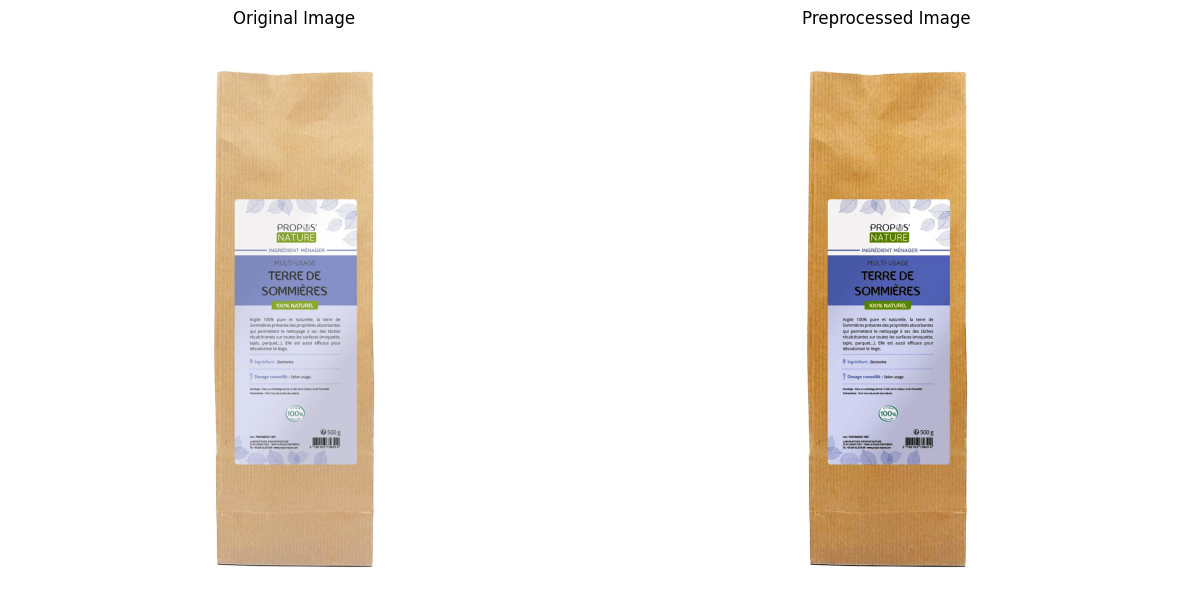

In [404]:
import cv2
import numpy as np
import requests
from PIL import Image, ImageEnhance
from io import BytesIO
import matplotlib.pyplot as plt

def fetch_image(url):
	response = requests.get(url)
	return Image.open(BytesIO(response.content))

def preprocess_image(image, target_size=(1200, 900), contrast_factor=1.5):
	open_cv_image = np.array(image)

	# Resize the image
	resized_image = cv2.resize(open_cv_image, target_size, interpolation=cv2.INTER_LINEAR)

	enhancer = ImageEnhance.Contrast(image)
	enhanced_image = enhancer.enhance(contrast_factor)
	open_cv_image = np.array(enhanced_image)

	sharpening_kernel = np.array([[-1, -1, -1], 
	                              [-1,  9, -1],
	                              [-1, -1, -1]])
	sharpened_image = cv2.filter2D(open_cv_image, -1, sharpening_kernel)
	
	filtered_image = cv2.bilateralFilter(sharpened_image, 9, 75, 75)


	gray_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)

	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
	clahe_image = clahe.apply(gray_image)

	binary_image = cv2.adaptiveThreshold(clahe_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

	blurred_image = cv2.medianBlur(binary_image, 5)

	# Edge detection
	edges = cv2.Canny(blurred_image, 100, 200)

	# Convert the preprocessed image back to PIL
	preprocessed_pil_image = Image.fromarray(edges)
	
	return preprocessed_pil_image, enhanced_image

def display_comparison(original_image, preprocessed_image):
	fig, axes = plt.subplots(1, 2, figsize=(12, 6))

	# Original Image
	axes[0].imshow(original_image)
	axes[0].set_title('Original Image')
	axes[0].axis('off')

	# Preprocessed Image
	axes[1].imshow(preprocessed_image, cmap='gray')
	axes[1].set_title('Preprocessed Image')
	axes[1].axis('off')

	plt.tight_layout() 
	plt.show()


image_url = 'https://m.media-amazon.com/images/I/31EvJszFVfL.jpg'  # Replace wit image URL
image_url = 'https://m.media-amazon.com/images/I/61I9XdN6OFL.jpg'  # Replace wit image URL
original_image = fetch_image(image_url)
preprocessed_image, enhanced_image = preprocess_image(original_image)
display_comparison(original_image, enhanced_image)

